In [1]:
import os
import numpy as np
import pandas as pd
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
import gwdetchar.omega.plot
import matplotlib.pyplot as plt
from gwpy.plot import Plot
from gwpy.time import to_gps, from_gps, tconvert
from astropy.time import Time
from scipy import signal
from gwtrigfind import find_trigger_files
from scipy.signal import savgol_filter
%matplotlib inline

In [62]:
tstart = Time('2020-01-26 07:10:00', format='iso', scale='utc')
tend = Time('2020-01-26 08:10:00', format='iso', scale='utc')

filedate = '200126_0710_0810' #YYMMDD_start_end
Dir = 'scatter_data/'

In [3]:
#read h(t) calib strain data
gwdata = TimeSeries.read(Dir + 'L1calibstrain_' + filedate + '.txt') 

### **Omicron Glitches**

In [4]:
#get omicron triggers and filter to lower frequencies
omtrigsdf = pd.read_csv('scatter_data/L1calibtriggers' + filedate + '.csv')
omtrigs = omtrigsdf[omtrigsdf['frequency'].between(1, 50)]
print(len(omtrigs))

519


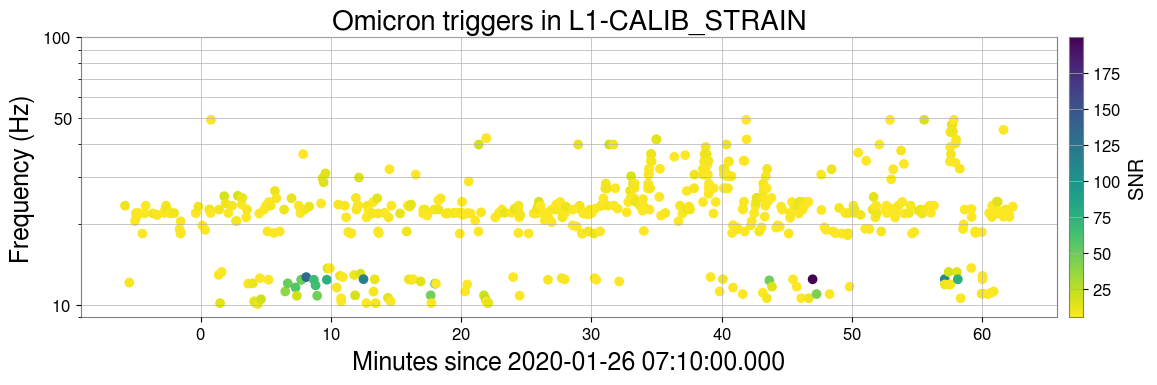

In [5]:
#glitches during hour of earthquake
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title('Omicron triggers in L1-CALIB_STRAIN', fontsize=20)
plt.scatter((omtrigs.time-tstart.gps)/60, omtrigs.frequency, c=omtrigs.snr, cmap='viridis_r')
plt.ylim(9,100)
plt.yscale('log')
plt.grid('visible','both')
plt.xlabel('Minutes since ' + str(tstart),fontsize=18)
plt.ylabel('Frequency (Hz)',fontsize=18)
plt.colorbar(cmap='viridis_r', label='SNR', pad=0.01)
plt.show()

### **Spectrograms**

In [27]:
#Q-tranforms of gw data for +/- delta seconds around t_0
#determine how much time to shift by looking at glitches plot
t_0 = tstart.gps + 8*60 + 28 
delta = 30

gw = gwdata.crop(start = t_0-delta, end = t_0+delta)
    
qspecgram = gw.q_transform(frange = (4,512), qrange = (4,32))

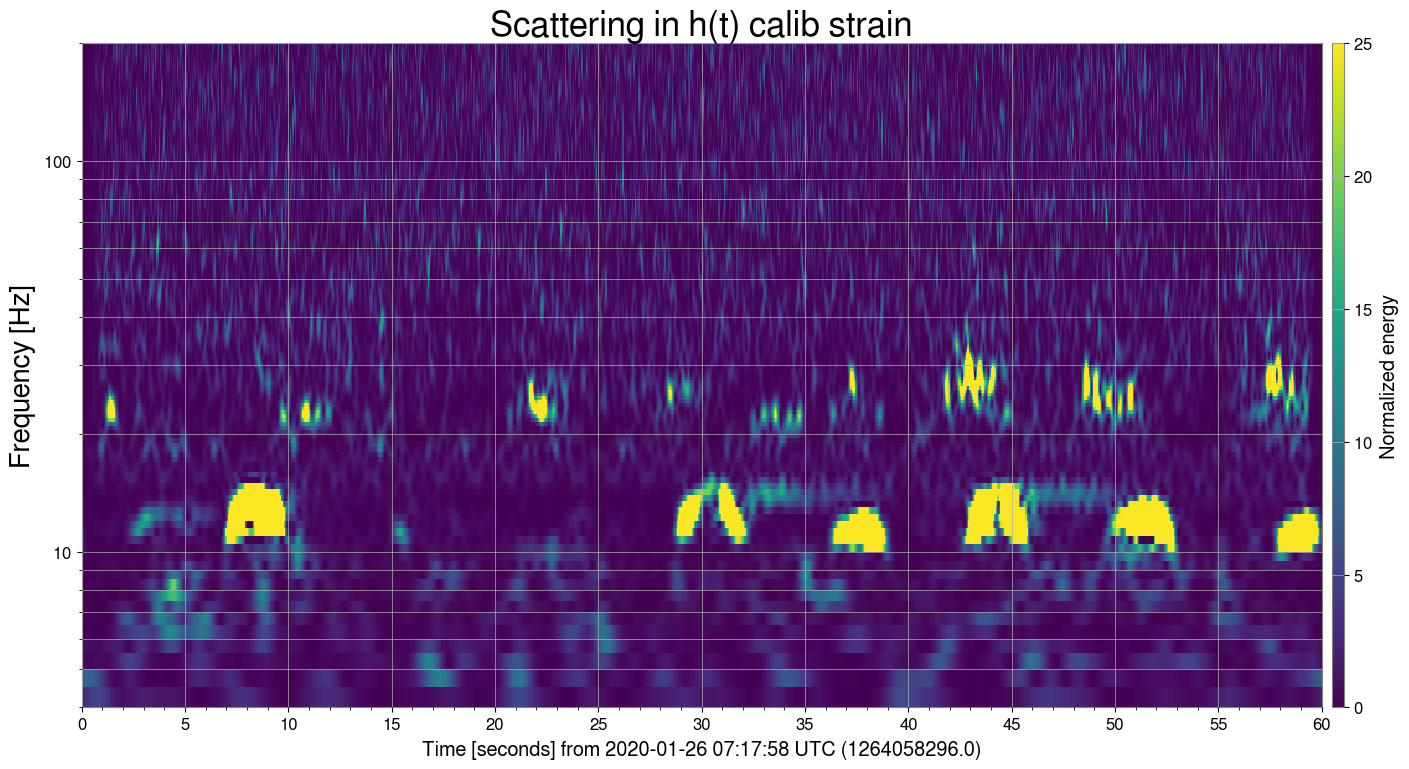

In [28]:
plot = qspecgram.plot(figsize=[16, 8], vmin=0, vmax=25)
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(4,200)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plt.title("Scattering in h(t) calib strain", fontsize=25)
plot.show()

In [29]:
#find minute with no glitch
ng_data = gwdata.crop(start=tstart.gps, end=tstart.gps+60)
ng_qspecgram = ng_data.q_transform(frange = (4,512), qrange = (4,32))

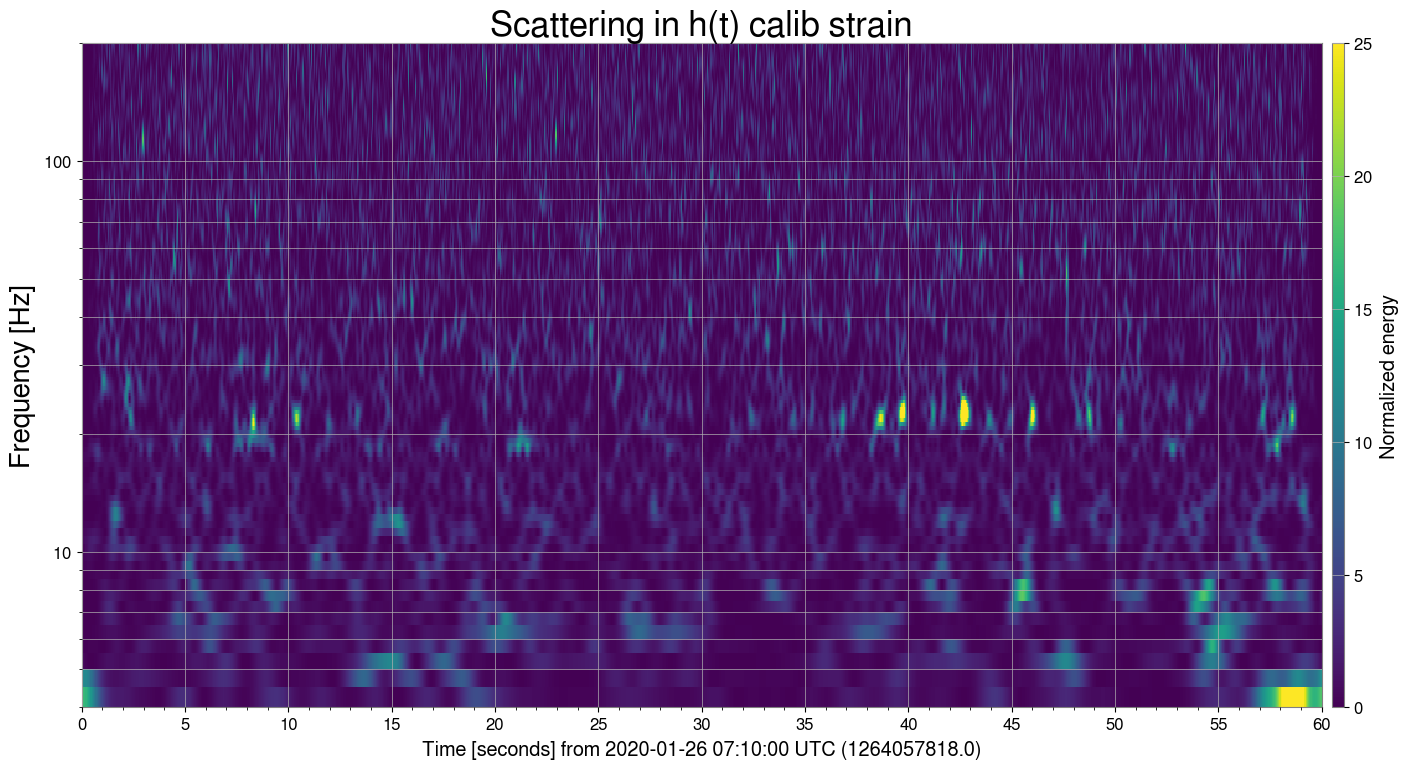

In [30]:
ng_plot = ng_qspecgram.plot(figsize=[16, 8], vmin=0, vmax=25)
ax = ng_plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(4,200)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plt.title("Scattering in h(t) calib strain", fontsize=25)
plot.show()

### **Arches**

In [31]:
#get suspension data
susdata = TimeSeries.read('scatter_data/L1sus_ETMX_DQ_' + filedate + '.txt') #also do for drive

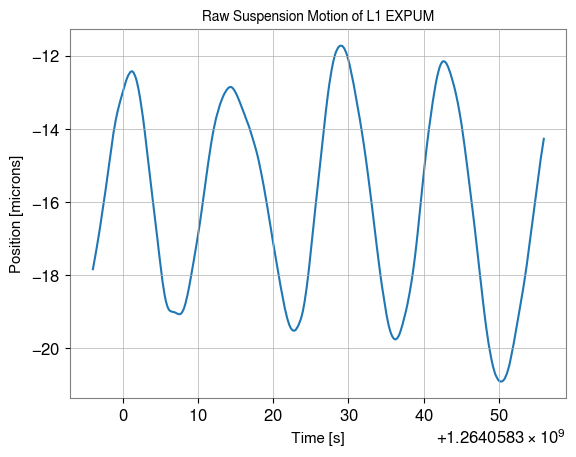

In [32]:
#crop data
sus = susdata.crop(start=t_0-delta, end=t_0+delta)

plt.title('Raw Suspension Motion of L1 EXPUM', fontsize=10)
plt.plot(sus)
plt.xlabel('Time [s]', fontsize=11)
plt.ylabel('Position [microns]', fontsize=11)
plt.show()

In [33]:
#relative motion (nm)
t0 = sus.t0.value
dt = sus.dt.value
t = np.linspace(0,(len(sus)-1)*dt, len(sus))

#plt.figure(figsize=(12,6))
#plt.plot(t, sus)
#plt.xlabel('Time [s] since ' + str(sus.t0))
#plt.title('L1 EXPUM')

In [34]:
#take derivative of motion to get velocity
v = np.diff(sus)/dt
tv = t[1:]

#plt.plot(tv, v)
#plt.xlabel('Time [s]')
#plt.ylabel('Velocity [microns/s]')
#plt.show()

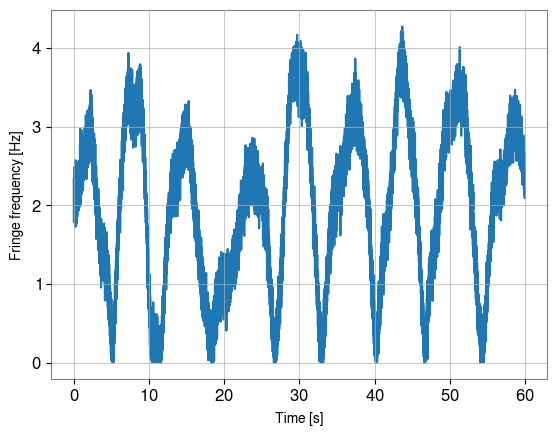

In [35]:
#calculate fringe frequency
wl = 1.064 #micrometers
ff = (abs(2*v/wl))

plt.plot(tv, ff)
plt.xlabel('Time [s]', size=10)
plt.ylabel('Fringe frequency [Hz]', size=10)
plt.show()

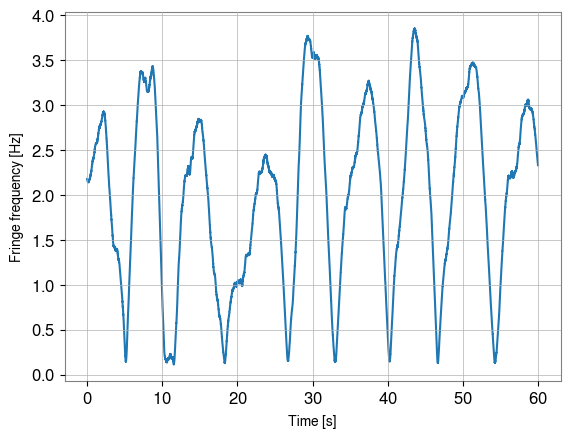

In [36]:
#smooth the graph
ff_filt = savgol_filter(ff, window_length=101, polyorder=2)

plt.plot(tv, ff_filt)
plt.xlabel('Time [s]', size=10)
plt.ylabel('Fringe frequency [Hz]', size=10)
plt.show()

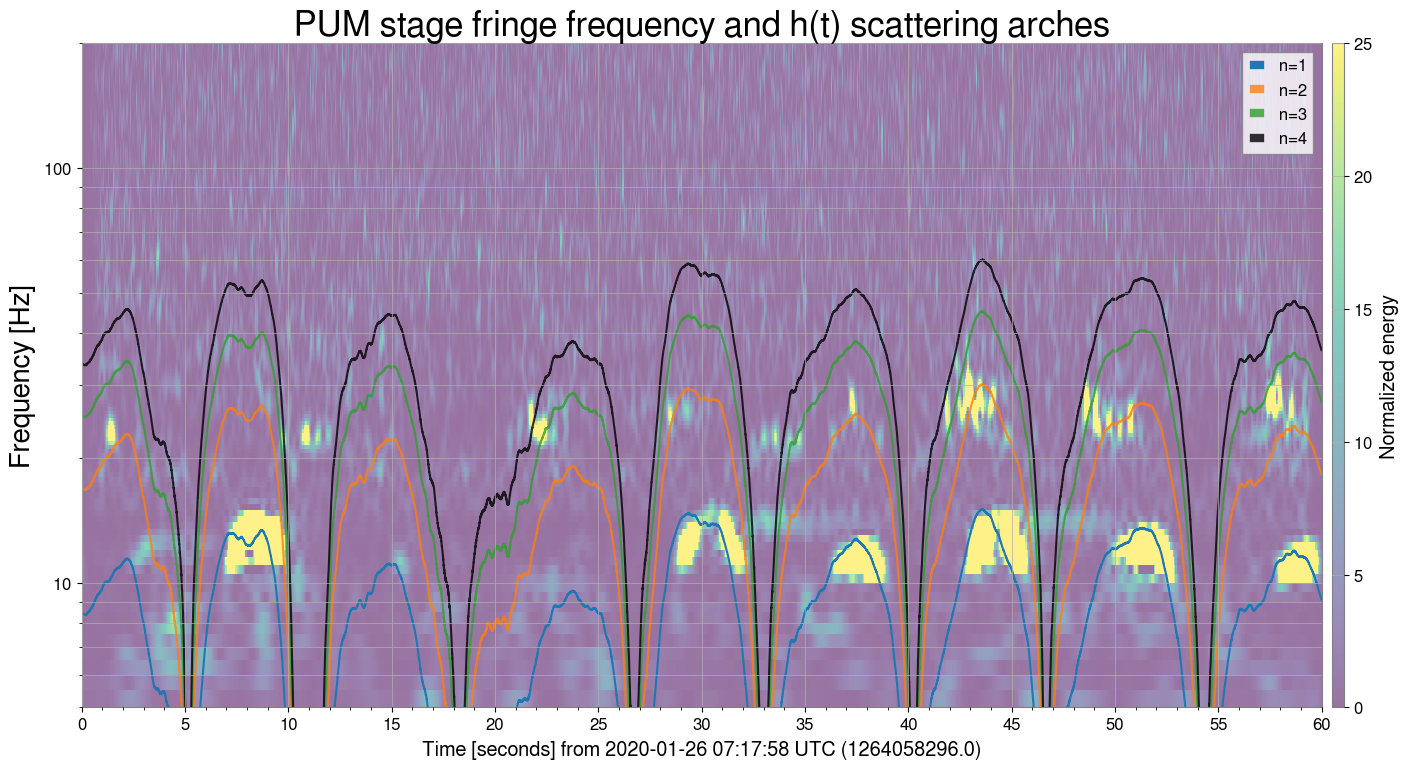

In [60]:
plot = qspecgram.plot(figsize=[16, 8], alpha=0.55)
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(5,200)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])

#multiply fringe freq motion by 1.3*n to get the nth harmonic
calib = 1.3*3
fringe = calib*ff_filt

plt.title("PUM stage fringe frequency and h(t) scattering arches", fontsize=25)
plt.plot(tv + (t_0-delta), fringe, label='n=1')
plt.plot(tv + (t_0-delta), 2*fringe, alpha=0.8, label='n=2')
plt.plot(tv + (t_0-delta), 3*fringe, alpha=0.8, label='n=3')
plt.plot(tv + (t_0-delta), 4*fringe, alpha=0.8, color='k', label='n=4')
plt.legend()

plot.show()

### **Transmon**

In [42]:
ascdata = TimeSeries.read(Dir + 'L1asc_trA_ETMX_DQ_' + filedate + '.txt')

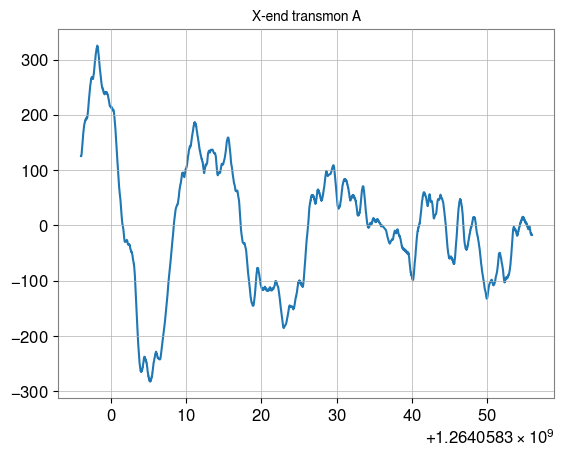

In [43]:
#crop data
asc = ascdata.crop(start=t_0-delta, end=t_0+delta)
asc = asc.detrend()

plt.title('X-end transmon A', fontsize=10)
plt.plot(asc) #makes linear fit, subtracts mean
plt.show()

In [44]:
trqspecgram = asc.q_transform(frange = (4,512), qrange = (4,32))

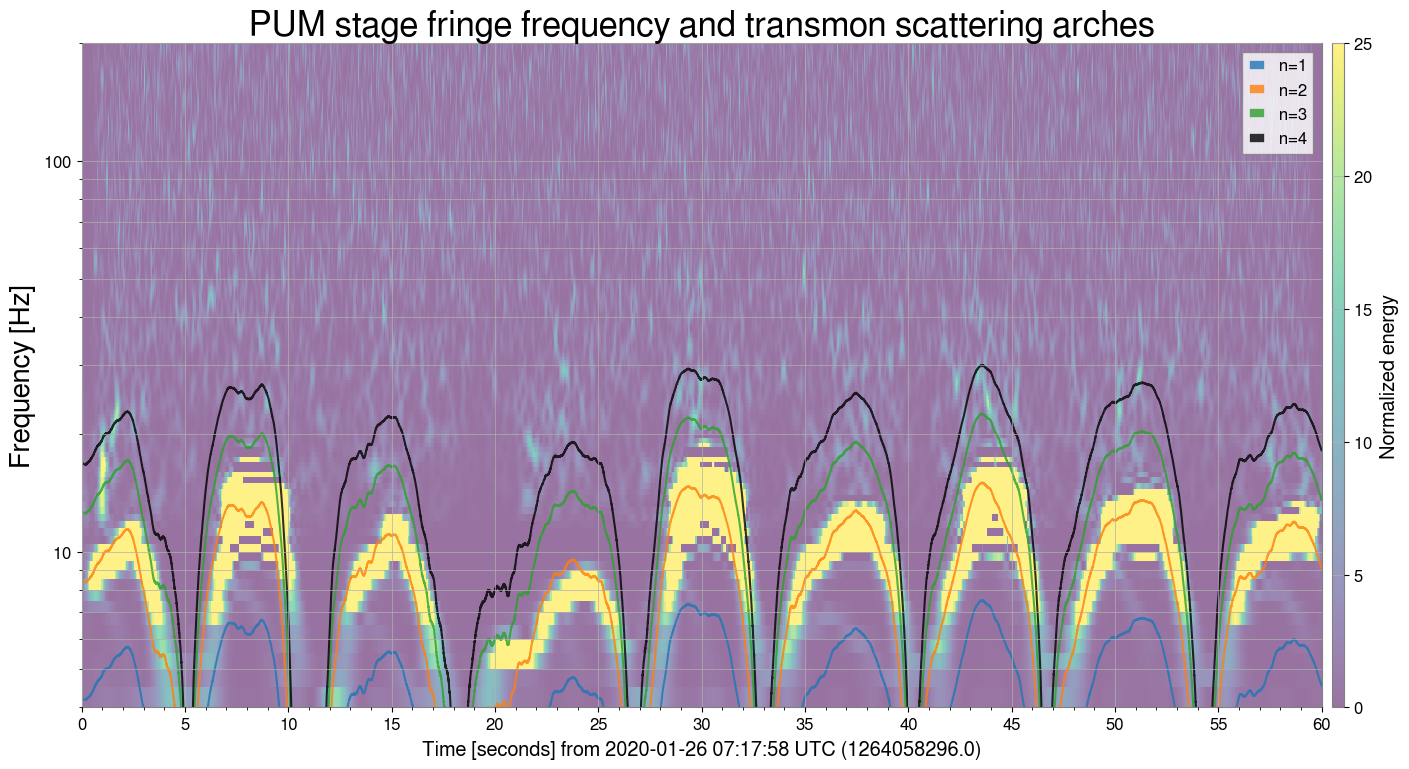

In [61]:
plot = trqspecgram.plot(figsize=[16, 8], alpha=0.55)
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(4,200)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])

#arches in transmon is 1/2 freq of PUM arches
tr_fringe = 0.5*fringe

plt.title("PUM stage fringe frequency and transmon scattering arches", fontsize=25)
plt.plot(tv + (t_0-delta), tr_fringe, alpha=0.8, label='n=1')
plt.plot(tv + (t_0-delta), 2*tr_fringe, alpha=0.8, label='n=2')
plt.plot(tv + (t_0-delta), 3*tr_fringe, alpha=0.8, label='n=3')
plt.plot(tv + (t_0-delta), 4*tr_fringe, alpha=0.8, color='k', label='n=4')
plt.legend()

plot.show()

### **Amplitude Spectral Density**

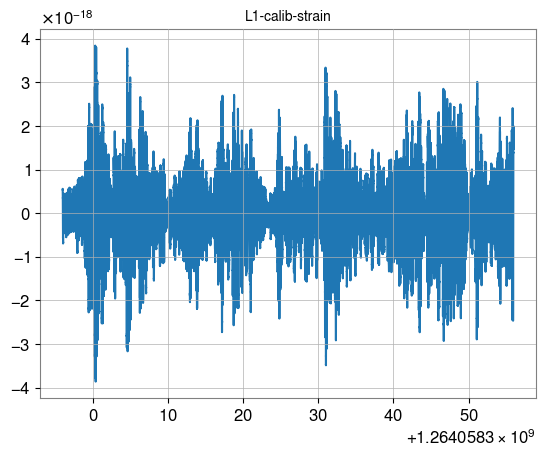

In [46]:
#asd of cropped signal in h(t)
gw = gw.detrend()

plt.title('L1-calib-strain', fontsize=10)
plt.plot(gw) #makes linear fit, subtracts mean
plt.show()

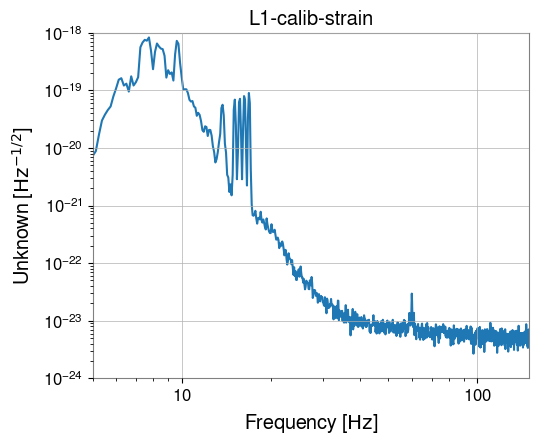

In [47]:
#asd of cropped signal in h(t) #this is for minute with scattering
gw_asd = gw.asd(fftlength=8, overlap=4)

gw_plot = gw_asd.plot(label='glitch')
plt.title("L1-calib-strain")
ax.set_ylabel('ASD [Hz$^{-1/2}$]')
plt.ylim(1e-24, 1e-18)
plt.xlim(5,150)
plot.show()

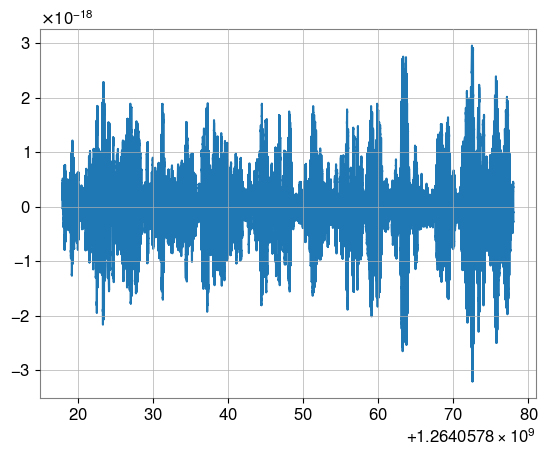

In [48]:
#no glitch segment in gw strain already defined
gw_ng = ng_data.detrend()

plt.plot(gw_ng)
plt.show()

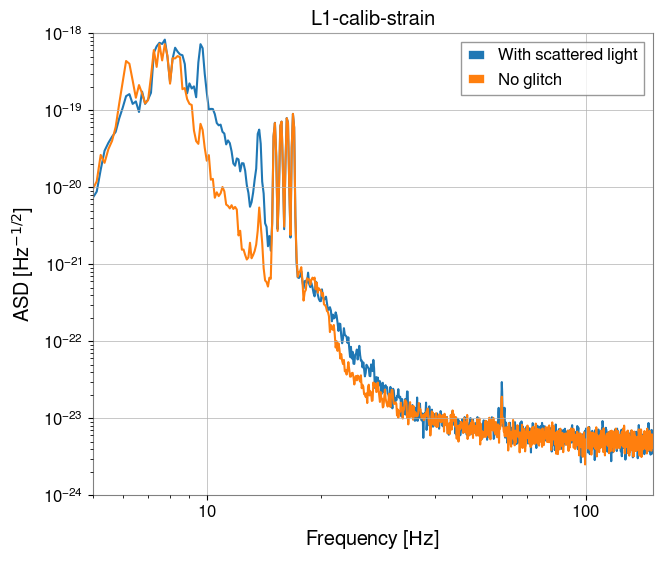

In [67]:
#asd of cropped signal in h(t) #this is for minute with scattering
gw_ng_asd = gw_ng.asd(fftlength=8, overlap=4)

gw_plot = gw_asd.plot(label="With scattered light", figsize=(8,6))
ax = gw_plot.gca()
ax.plot(gw_ng_asd, label="No glitch")

plt.title("L1-calib-strain")
ax.set_ylabel('ASD [Hz$^{-1/2}$]')
plt.ylim(1e-24, 1e-18)
plt.xlim(5,150)
plt.legend()
plot.show()

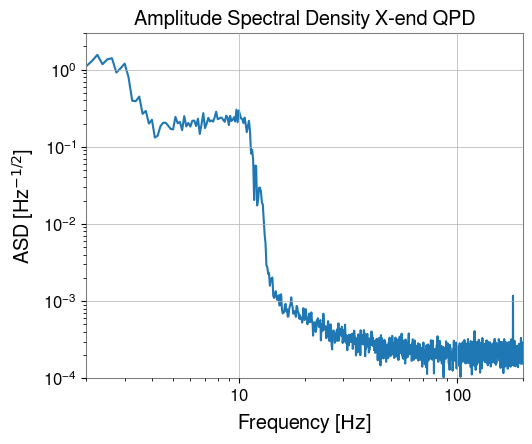

In [51]:
#asd of cropped signal in transmon #this is for minute with scattering
tr_asd = asc.asd(fftlength=8, overlap=4)

tr_plot = tr_asd.plot(label='asd')
ax = tr_plot.gca()
plt.title("Amplitude Spectral Density X-end QPD")
ax.set_ylabel('ASD [Hz$^{-1/2}$]')
plt.ylim(1e-4, 3)
plt.xlim(2,200)
plot.show()

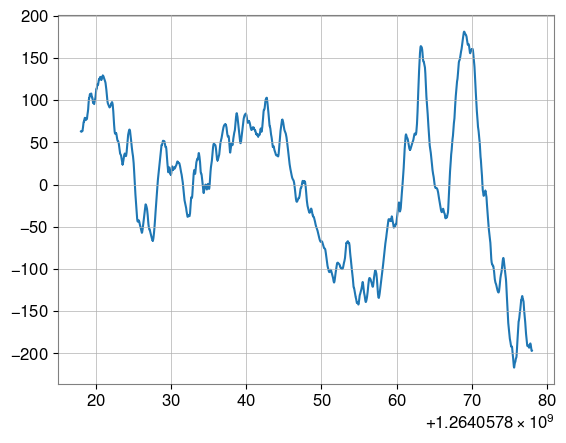

In [52]:
#no glitch segment in transmon
tr_ng = ascdata.crop(start=tstart.gps, end=tstart.gps+60)
tr_ng = tr_ng.detrend()

plt.plot(tr_ng)
plt.show()

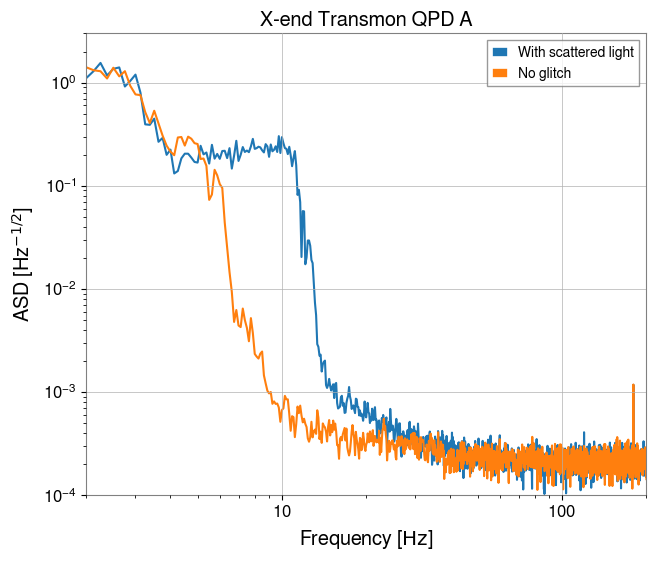

In [66]:
tr_ng_asd = tr_ng.asd(fftlength=8, overlap=4)

tr_plot = tr_asd.plot(label="With scattered light", figsize=(8,6))
ax = tr_plot.gca()
ax.plot(tr_ng_asd, label="No glitch")
plt.title("X-end Transmon QPD A")
ax.set_ylabel('ASD [Hz$^{-1/2}$]')
plt.legend(fontsize=10)
plt.ylim(1e-4, 3)
plt.xlim(2,200)
plot.show()

### **Earthquake**

In [22]:
eqtotdf = pd.read_csv("../eqlock/eqtotaldf_o3_30M_100M_LA.csv")

In [23]:
eqdf = eqtotdf[eqtotdf['Date'].between(tstart, tend)]
eqdf

Unnamed: 0.1  Unnamed: 0                 Date Broke Lock  Time of Peak  \
299            39          39  2020-01-26 07:23:00         No    1264058598   

     Vert. Vel.  Horiz. Vel.  Ratio V/H Time of Lost Lock (LL) LL Vert. Vel.  \
299   1249.1874   2832.21085   0.441064                      -             -   

    LL Horiz. Vel.  
299              -

In [24]:
peak = eqdf._get_value(eqdf.index[0], 'Time of Peak')
tdiff = peak-t_0

if tdiff>0:
    print("Scattering occurred " + str(tdiff) + " seconds before earthquake peak.")
if tdiff==0:
    print("Scattering occurred at the same time as earthquake peak.")
if tdiff<0:
    print("Scattering occurred " + str(-tdiff) + " seconds after earthquake peak.")

Scattering occurred 270.0 seconds before earthquake peak.


In [43]:
#read earthquake data for vertical motion on x-end
eqdata = TimeSeries.read(Dir + 'L1seisETMX_Z_' + filedate + '.txt')
#eqdata = TimeSeries.read(Dir + 'L1seisETMX_Z_' + filedate + '_64Hz.txt')

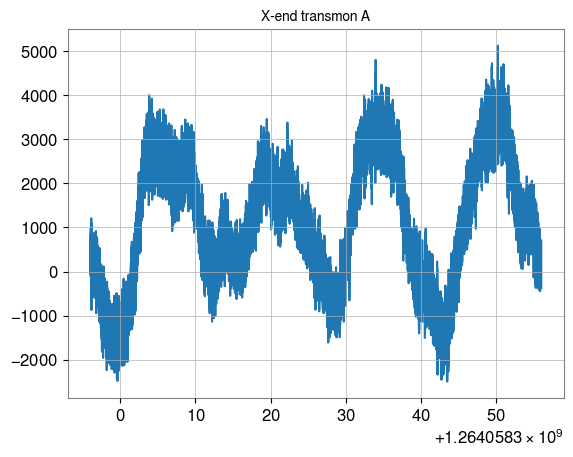

In [44]:
#crop data
eq = eqdata.crop(start=t_0-delta, end=t_0+delta)

plt.title('X-end transmon A', fontsize=10)
plt.plot(eq)
plt.show()

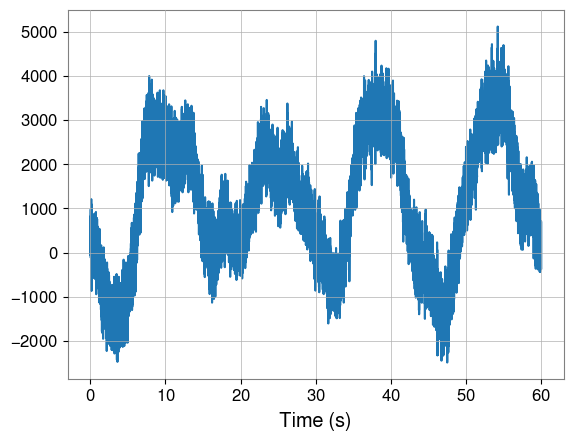

In [45]:
t0 = eq.t0.value
dt = eq.dt.value
t = np.linspace(0,(len(eq)-1)*dt, len(eq))

plt.plot(t, eq)
plt.xlabel('Time (s)')
plt.show()

Text(0, 0.5, 'Fringe frequency')

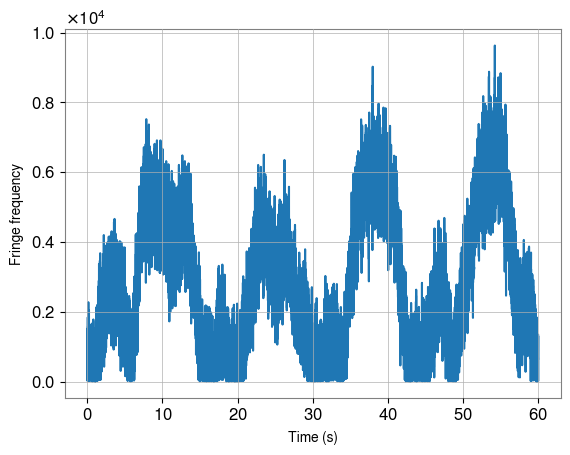

In [46]:
#calculate fringe frequency
wl = 1064 #nm
eqff = 1000*(abs(2*eq/wl))

plt.plot(t, eqff)
plt.xlabel('Time (s)', size=10)
plt.ylabel('Fringe frequency', size=10)

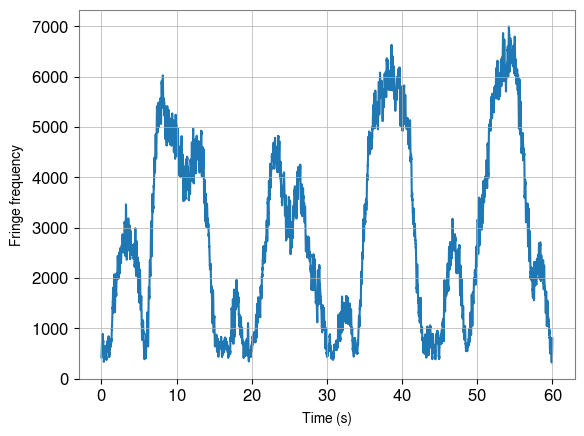

In [47]:
#smooth the graph
eqff_filt = savgol_filter(eqff, window_length=101, polyorder=2)

plt.plot(t, eqff_filt)
plt.xlabel('Time (s)', size=10)
plt.ylabel('Fringe frequency', size=10)
plt.show()

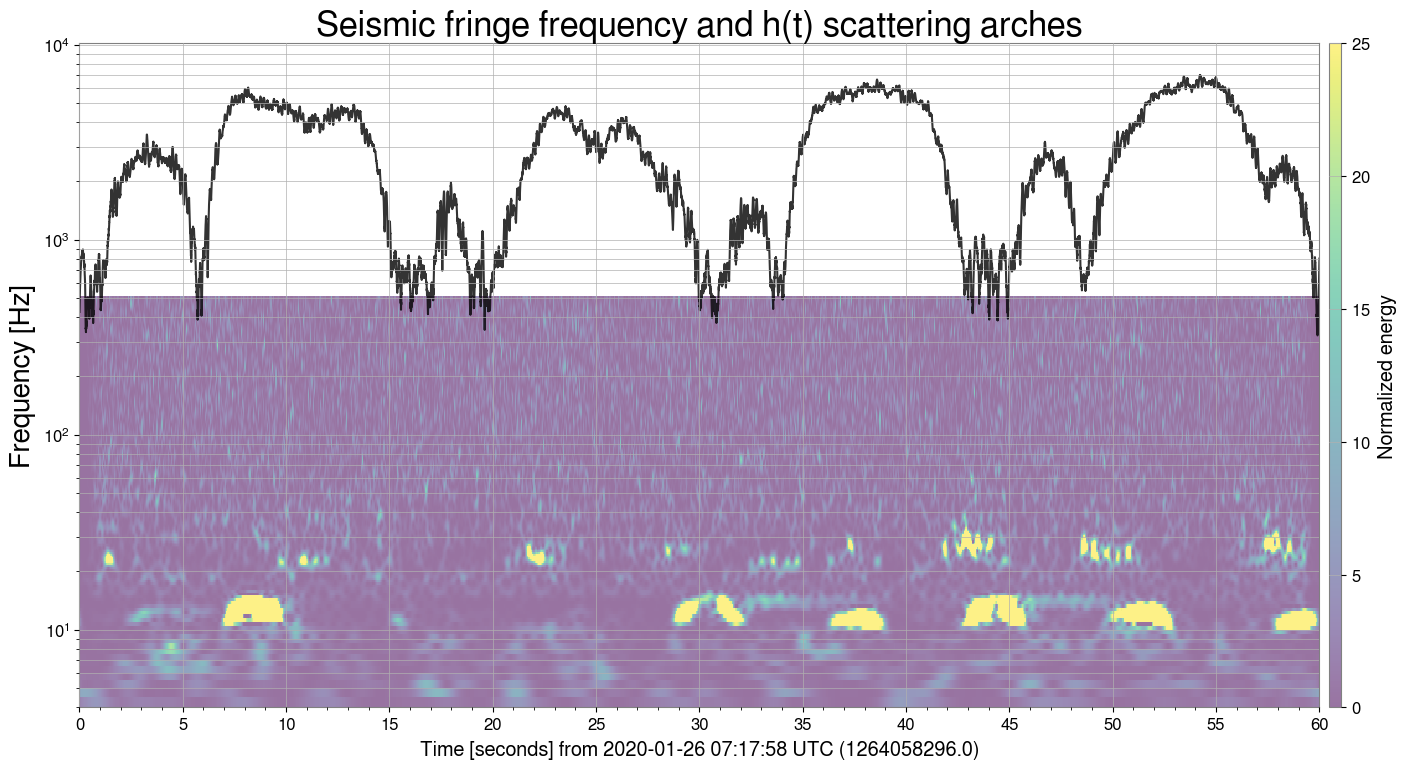

In [48]:
plot = qspecgram.plot(figsize=[16, 8], alpha=0.55)
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
#ax.set_ylim(5,150)
ax.set_ylabel('Frequency [Hz]', fontsize=20)
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])

plt.title("Seismic fringe frequency and h(t) scattering arches", fontsize=25)
plt.plot(t + (t_0-delta), eqff_filt, alpha=0.8, color='k')

plot.show()

In [ ]:
#can eliminate ground motion as surface causing scattering 2 ways: the above plot, and reverse calculate needed vel from ff equation (same thing)